Making a function for extracting transect and averaging across (perpendicular) by a certain number of pixels. 

In [1]:
# # import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import uniform_filter, gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import binned_statistic
%matplotlib  widget

Below is another test. I copied the code from my defined function and turned it into not a function. So I can plot things in between and make sure they are the same as the other notebook that works. <br> 
*cough cough* Please work. *cough cough*

dx = 766
dy = 155
11.439333010752343 degrees
rotation matrix: 
[[ 0.98013525  0.19833024]
 [-0.19833024  0.98013525]]
data1: 
[[-1.04044543e+03  +481.24884j  -1.34282129e+03  +649.37024j
   1.80673242e+03 -3036.2664j   ...  2.87975024e+03 -1340.4849j
  -1.72848206e+01  -970.6647j   -1.85345410e+03  -727.7157j  ]
 [-3.18088715e+02 -2074.671j     1.87689355e+03  -121.236145j
   9.03913696e+02  +190.17813j  ...  5.41819531e+03  -302.73938j
   5.92375293e+03 -3597.3438j    1.60774841e+02 -1875.23j    ]
 [-1.20672253e+03 -1495.5466j    1.03831018e+03  -502.84607j
   7.35980957e+02  -880.1285j   ... -7.11931763e+02 +4095.0916j
   9.96817444e+02  -174.22675j   1.00352954e+03 +1586.1042j  ]
 ...
 [-8.97819946e+02 +1884.188j     9.89183289e+02 -2115.0916j
  -1.75079102e+02  +215.51105j  ...  6.84112061e+03 +2244.1733j
   5.58079639e+03 +2370.615j     2.66551816e+04 +2372.4521j  ]
 [-1.17244641e+03 +2659.957j     3.90005200e+03  -615.114j
   8.49817200e+02 +1087.5476j   ...  1.12243125e+04 +3391

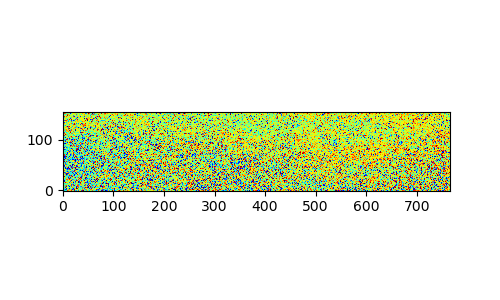

shape of extracted data rectangle: (155, 766)
x shape: (766,)
y shape: (155,)
grdx1 shape: (1, 118730)
grdy1 shape: (1, 118730)


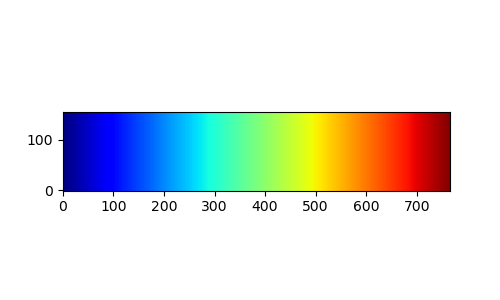

grd shape: (2, 118730)
newxy shape: (2, 118730)
new Xs: (155, 766)
new Ys: (155, 766)
max of x1: 780.3463261789099


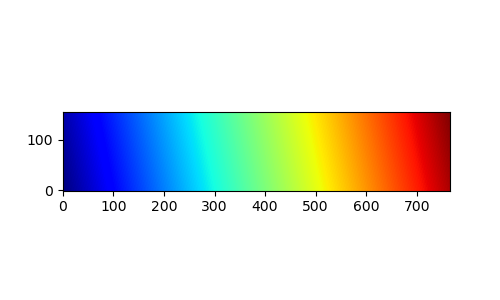

how many points within 5 of the transect?  7685
number of bins: 77
bins: (77,)
dists: (7685,)
vals: (7685,)
binned vals: (77, 1)
reshaped binned vals type: <class 'numpy.complex128'>
output shape: (2, 77)
output[0] (=bins1 ?): 
output[1] (=binnedVals1 ?): 


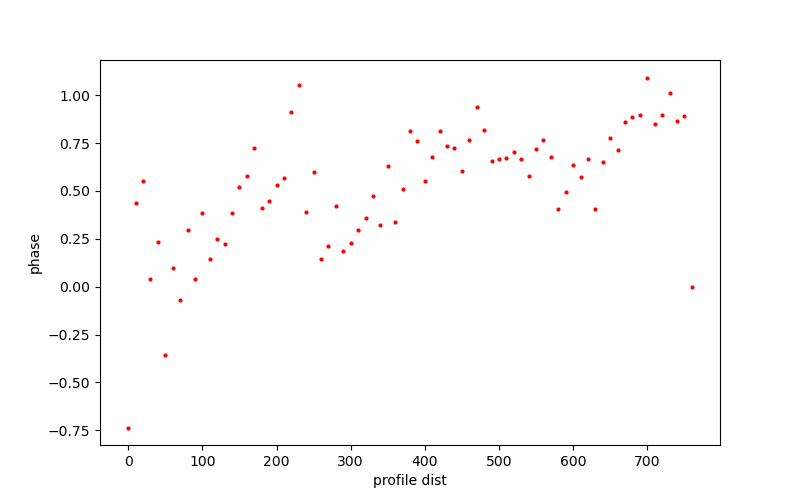

In [2]:
# trying the same code but not in a function: 
# set up an igram to use as the data array to input to function 
workdir = '/data/ocp4/LagunaSalada/'
cropdir='cropped_9000_1800_18000_3600/'
date1='20190112'
date2='20190124'
x0=0; dx=18000; y0=0; dy=3600 # changes with different subregion
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", \
               gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x0,y0,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", \
               gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x0,y0,dx,dy)
data = slc1 * np.conj(slc2)
start = [9234, 1345]
end = [10000, 1500]
perpDist = 5
binSize = 10

# here's where the function would start
# calculate angle needs to be rotated 
dx = (end[0]-start[0])
print('dx = '+str(dx))
dy = (end[1]-start[1])
print('dy = '+str(dy))
theta = np.arctan(dy/dx)
print(str(theta*180/np.pi)+' degrees')
# design rotation matrix 
rot = np.zeros((2,2),'float')
rot[0] = [np.cos(theta),np.sin(theta)]
rot[1] = [-np.sin(theta),np.cos(theta)]
print('rotation matrix: ')
print(rot)
# pull out only the relevant box within the data array [rows(y), columns(x)]
data1 = data[start[1]:end[1],start[0]:end[0]]
print('data1: ')
print(data1)
plt.figure(figsize=(5, 3))
plt.imshow(np.angle(data1),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
           interpolation='nearest',origin='lower')
plt.show()
print('shape of extracted data rectangle: '+str(np.shape(data1)))
# make a meshgrid for defining coordinates of the centers of pixels 
x = np.arange(0,dx,1)
y = np.arange(0,dy,1)
grdx,grdy = np.meshgrid(x,y,indexing='xy')
print('x shape: '+str(np.shape(x)))
print('y shape: '+str(np.shape(y)))
# reshape these to be x in first column, y in second column 
grdx1 = grdx.reshape(1,dx*dy)
grdy1 = grdy.reshape(1,dx*dy)
print('grdx1 shape: '+str(np.shape(grdx1)))
print('grdy1 shape: '+str(np.shape(grdy1)))
grd = np.vstack((grdx1,grdy1)) 
plt.figure(figsize=(5, 3))
plt.imshow(grdx, cmap='jet', aspect='equal', \
           interpolation='nearest',origin='lower')
plt.show()
print('grd shape: '+str(np.shape(grd)))
newxy = np.matmul(rot,grd)
print('newxy shape: '+str(np.shape(newxy)))
#reshape again
x1 = newxy[0,:].reshape((dy,dx)) # this is distance along transect
y1 = newxy[1,:].reshape((dy,dx)) # this is distance perpendicular to transect
print('new Xs: '+str(np.shape(x1)))
print('new Ys: '+str(np.shape(y1)))
print('max of x1: '+str(np.max(x1)))
plt.figure(figsize=(5, 3))
plt.imshow(x1, cmap='jet', aspect='equal',origin='lower')
plt.show()
# which points are within perpDist of the transect
ind = np.where(np.abs(y1) < perpDist)
print('how many points within '+str(perpDist)+' of the transect?  '+str(np.shape(ind)[1]))
# bin the data, can change bin width with last input into function
bins = np.arange(0,dx,binSize)
numBins = np.shape(bins)[0]
print('number of bins: '+str(numBins))
print('bins: '+str(np.shape(bins)))
dists = x1[ind]
print('dists: '+str(np.shape(dists)))
vals = data1[ind]
print('vals: '+str(np.shape(vals)))
binnedVals=np.ndarray([len(bins),1],'complex')
print('binned vals: '+str(np.shape(binnedVals)))
# find which values are in which bins and average them 
for i in np.arange(len(bins)-1):
    inds = (np.where((dists >= bins[i]) & (dists < bins[i+1])))
    binnedVals[i]= np.mean(vals[inds]) 
# put bins and binnedVals together in an array to be the output of the function 
# must reshape them first so that they are (1,n) dimensions
bins1 = bins.reshape((1,numBins))
binnedVals1 = binnedVals.reshape((1,numBins))
print('reshaped binned vals type: '+str(type(binnedVals1[0,0])))
output = np.vstack((bins1,binnedVals1))
print('output shape: '+str(np.shape(output)))
print('output[0] (=bins1 ?): ')
#print(output[0].real)
print('output[1] (=binnedVals1 ?): ')
#print(output[1])
plt.figure(figsize=(8, 5))
plt.plot(np.real(output[0]),np.angle(output[1]),'r.',markersize=4)
plt.ylabel('phase'); plt.xlabel('profile dist')
plt.show()
# output is all complex so we have to take the real part of the bins = output[0] 
# to plot it without having an issue with casting complex values

In [32]:
# data must be an array (can be complex values or not)
# start is [x, y] coordinate of starting point of transect 
#     start[0] is the x coord
#     start[1] is the y coord
#     end[0] is the x coord
#     end[1] is the y coord
# end is [x, y] coordinate of ending point of transect
# across is the transect-perpendicular distance you want to average over 

def extract_transect(data, start, end, perpDist, binSize):
    # calculate angle needs to be rotated 
    dx = (end[0]-start[0])
    print('dx = '+str(dx))
    dy = (end[1]-start[1])
    print('dy = '+str(dy))
    theta = np.arctan(dy/dx)
    print(str(theta*180/np.pi)+' degrees')
    # design rotation matrix 
    rot = np.zeros((2,2),'float')
    rot[0] = [np.cos(theta),np.sin(theta)]
    rot[1] = [-np.sin(theta),np.cos(theta)]
    print('rotation matrix: ')
    print(rot)
    # pull out only the relevant box within the data array [rows(y), columns(x)]
    data1 = data[start[1]:end[1],start[0]:end[0]]
    print('shape of extracted data rectangle: '+str(np.shape(data1)))
    print('first few values in data1: ')
    print(data1)
    plt.figure(figsize=(5, 3))
    plt.imshow(np.angle(data1),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
           interpolation='nearest',origin='lower')
    plt.show()
    # make a meshgrid for defining coordinates of the centers of pixels 
    x = np.arange(0,dx,1)
    y = np.arange(0,dy,1)
    grdx,grdy = np.meshgrid(x,y,indexing='xy')
    print('x shape: '+str(np.shape(x)))
    print('y shape: '+str(np.shape(y)))
    # reshape these to be x in first column, y in second column 
    grdx1 = grdx.reshape(1,dx*dy)
    grdy1 = grdy.reshape(1,dx*dy)
    print('grdx1 shape: '+str(np.shape(grdx1)))
    print('grdy1 shape: '+str(np.shape(grdy1)))
    grd = np.vstack((grdx1,grdy1)) 
    print('grd shape: '+str(np.shape(grd)))
    newxy = np.matmul(rot,grd)
    #reshape again
    x1 = newxy[0,:].reshape((dy,dx)) # this is distance along transect
    y1 = newxy[1,:].reshape((dy,dx)) # this is distance perpendicular to transect
    print('new Xs: '+str(np.shape(x1)))
    print('new Ys: '+str(np.shape(y1)))
    # which points are within perpDist of the transect
    ind = np.where(np.abs(y1) < perpDist)
    print('how many points within '+str(perpDist)+' of the transect?  '+str(np.shape(ind)))
    print('first few indices: ')
    print(ind[0:10])
    # bin the data, can change bin width with last input into function
    bins = np.arange(0,dx,binSize)
    numBins = np.shape(bins)[0]
    print('bins: '+str(np.shape(bins)))
    dists = x1[ind]
    print('dists: '+str(np.shape(dists)))
    vals = data1[ind]
    print('vals: '+str(np.shape(vals)))
    binnedVals=np.ndarray([len(bins),1],'complex')
    print('binned vals: '+str(np.shape(binnedVals)))
    # find which values are in which bins and average them 
    for i in np.arange(len(bins)-1):
        inds = (np.where((dists >= bins[i]) & (dists < bins[i+1])))
        binnedVals[i]= np.mean(vals[inds]) 
    # put bins and binnedVals together in an array to be the output of the function 
    # must reshape them first so that they are (1,n) dimensions
    bins1 = bins.reshape((1,numBins))
    binnedVals1 = binnedVals.reshape((1,numBins))
    output = np.vstack((bins1,binnedVals1))
    print('output shape: '+str(np.shape(output)))
    return output

TEST the function at various stages <br>
**remember to put the above code into the extract_transect.py file once I have it right

In [4]:
# set up an igram to use as the data array to input to function 
workdir = '/data/ocp4/LagunaSalada/'
cropdir='cropped_9000_1800_18000_3600/'
date1='20190112'
date2='20190124'
x0=0; dx=18000; y0=0; dy=3600 # changes with different subregion
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", \
               gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x0,y0,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", \
               gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x0,y0,dx,dy)
int12 = slc1 * np.conj(slc2)

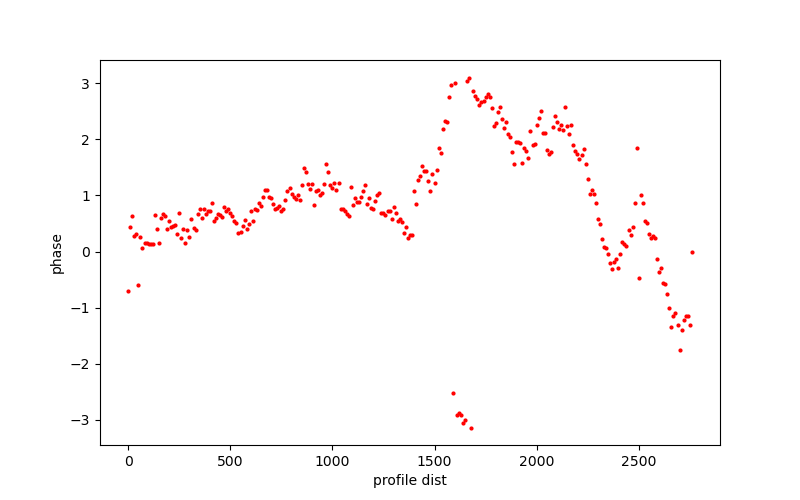

In [5]:
# define the points you want the transect to be between
testStart = [9234, 1345]
testEnd = [12000, 2000]

#print(np.shape(int12))

testResults = extract_transect(int12, testStart, testEnd, 5, 10)
#print(testResults)

plt.figure(figsize=(8, 5))
plt.plot(np.real(testResults[0]),np.angle(testResults[1]),'r.',markersize=4)
plt.ylabel('phase'); plt.xlabel('profile dist')
plt.show()

In [38]:
# Print out the first five values of the indices to compare with the other notebook
print('bins 1-10: ')
print(np.real(testResults[0,0:10]))
print('binnedVals 1-10: ')
print(np.angle(testResults[1,0:10]))

bins 1-10: 
[ 0. 10. 20. 30. 40. 50. 60. 70. 80. 90.]
binnedVals 1-10: 
[-0.18964111 -0.57977532 -0.41014237 -0.26115122 -0.32769175 -0.42516738
 -0.44550025 -0.5615912  -0.06851082 -0.59241479]


WOHOO they are the same!!

In [33]:
# do another test. Wasn't working with 2_pixel_comparison notebook as of 6-23-22

dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vv/2*")]
dates=sorted(dates)
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
x1=9234   
y1=1345   
x2=10000   
y2=1500  
Dx = x2-x1
Dy = y2-y1
# what slc date do I want to start at? then convert to datetime object.
# try '20200711' next
startDate = '20190711'
date1 = datetime.strptime(str(startDate).replace('\n',''), '%Y%m%d')
# find which index corresponds to this date: 
indexDate1 = slc_dates.index(date1)
print(indexDate1)
# how many slcs do I need to load? 
numigrams = 4
numSLCs = numigrams+1
# loop through and load in the slcs, extract the data
SLCs=np.ndarray([numSLCs,Dy,Dx],'complex')
# defined above: 
print('shape of SLCs array: '+str(np.shape(SLCs)))
# starts at the first date, goes through the number of igrams defined above
for i in np.arange(indexDate1, indexDate1+numSLCs):
    ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                    gdal.GA_ReadOnly)
    SLCs[i-indexDate1,:,:] = ds.GetRasterBand(1).ReadAsArray(x1,y1,Dx,Dy)
    print('slc '+str(i))  
# now we have all the SLCs extracted, make igrams 
igrams = SLCs[0:-1,:,:]*np.conj(SLCs[1:,:,:])
print('igrams made for small area')
print('shape of igrams array: '+str(np.shape(igrams)))

64
shape of SLCs array: (5, 155, 766)
slc 64
slc 65
slc 66
slc 67
slc 68
igrams made for small area
shape of igrams array: (4, 155, 766)


[9234, 1345]
dx = 766
dy = 155
11.439333010752343 degrees
rotation matrix: 
[[ 0.98013525  0.19833024]
 [-0.19833024  0.98013525]]
shape of extracted data rectangle: (0, 0)
first few values in data1: 
[]


/tmp/ipykernel_5551/1371327467.py:30: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(np.angle(data1),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
/tmp/ipykernel_5551/1371327467.py:30: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(np.angle(data1),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \


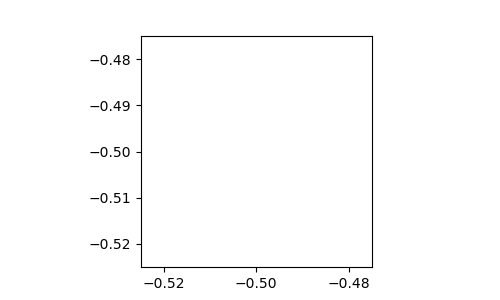

x shape: (766,)
y shape: (155,)
grdx1 shape: (1, 118730)
grdy1 shape: (1, 118730)
grd shape: (2, 118730)
new Xs: (155, 766)
new Ys: (155, 766)
how many points within 15 of the transect?  (2, 22287)
first few indices: 
(array([  0,   0,   0, ..., 154, 154, 154]), array([  0,   1,   2, ..., 763, 764, 765]))
bins: (154,)
dists: (22287,)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [34]:
start1 = [x1, y1]
end1 = [x2, y2]
perpDist1 = 15
binSize1 = 5

print(start1)
transectTest = extract_transect(igrams[3], start1, end1, perpDist1, binSize1)
print(np.shape(transectTest))